In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
def load_data():
    train = pd.read_csv('titanic/train.csv')
    test = pd.read_csv('titanic/test.csv')
    submission = pd.read_csv('titanic/gender_submission.csv')

    test = test.merge(submission, on='PassengerId')

    def preprocess(df):
        df = df.copy()
        df['Age'] = df['Age'].fillna(df['Age'].median())
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        df['Embarked'] = df['Embarked'].fillna('S')

        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
        df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
        df['FamilySize'] = df['SibSp'] + df['Parch']
        return df

    train = preprocess(train)
    test = preprocess(test)

    features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']
    X_train = train[features].values
    y_train = train['Survived'].values
    X_test = test[features].values
    y_test = test['Survived'].values

    # Normalize features using Min-Max Scaling
    min_vals = X_train.min(axis=0)
    max_vals = X_train.max(axis=0)
    X_train = (X_train - min_vals) / (max_vals - min_vals + 1e-9)
    X_test = (X_test - min_vals) / (max_vals - min_vals + 1e-9)

    return X_train, y_train, X_test, y_test

In [28]:
def naive_bayes(X_train, y_train):
    classes = np.unique(y_train)
    params = {}
    for c in classes:
        X_c = X_train[y_train == c]
        means = np.mean(X_c, axis=0)
        stds = np.std(X_c, axis=0)
        stds = np.where(stds == 0, 1e-9, stds)
        params[c] = (means, stds)
    return params

def predict_naive_bayes(model, X):
    predictions = []
    for x in X:
        class_probs = []
        for c, (means, stds) in model.items():
            log_prob = -0.5 * np.sum(np.log(2 * np.pi * stds**2 + 1e-9))
            log_prob -= np.sum(((x - means)**2) / (2 * stds**2 + 1e-9))
            class_probs.append(log_prob)
        predictions.append(list(model.keys())[np.argmax(class_probs)])
    return np.array(predictions)

In [29]:
def knn(X_train, y_train, X_test, k=5):
    predictions = []
    for x in X_test:
        distances = []
        for train_x in X_train:
            dist = np.sqrt(np.sum((train_x - x)**2))
            distances.append(dist)
        distances = np.array(distances)
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        counts = np.zeros(np.max(y_train) + 1, dtype=int)
        for label in nearest_labels:
            counts[label] += 1
        predictions.append(np.argmax(counts))
    return np.array(predictions)

In [30]:
def evaluate(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2%}")

    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    cm = {c: {d: 0 for d in unique_classes} for c in unique_classes}
    for actual, pred in zip(y_true, y_pred):
        cm[actual][pred] += 1

    print("Confusion Matrix:")
    print("\t" + "\t".join(str(c) for c in unique_classes))
    for actual in unique_classes:
        row = [str(cm[actual][pred]) for pred in unique_classes]
        print(f"{actual}\t" + "\t".join(row))

    return accuracy

In [31]:
def plot_accuracies(accuracies, labels):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies, color=['blue', 'green', 'orange', 'red'])
    plt.title('Model Accuracy Comparison on Titanic Dataset')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 0.9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png')
    plt.show()

Naive Bayes Accuracy: 91.39%
Confusion Matrix:
	0	1
0	235	31
1	5	147
KNN (k=3) Accuracy: 71.77%
Confusion Matrix:
	0	1
0	190	76
1	42	110
KNN (k=5) Accuracy: 75.84%
Confusion Matrix:
	0	1
0	194	72
1	29	123
KNN (k=7) Accuracy: 88.04%
Confusion Matrix:
	0	1
0	243	23
1	27	125


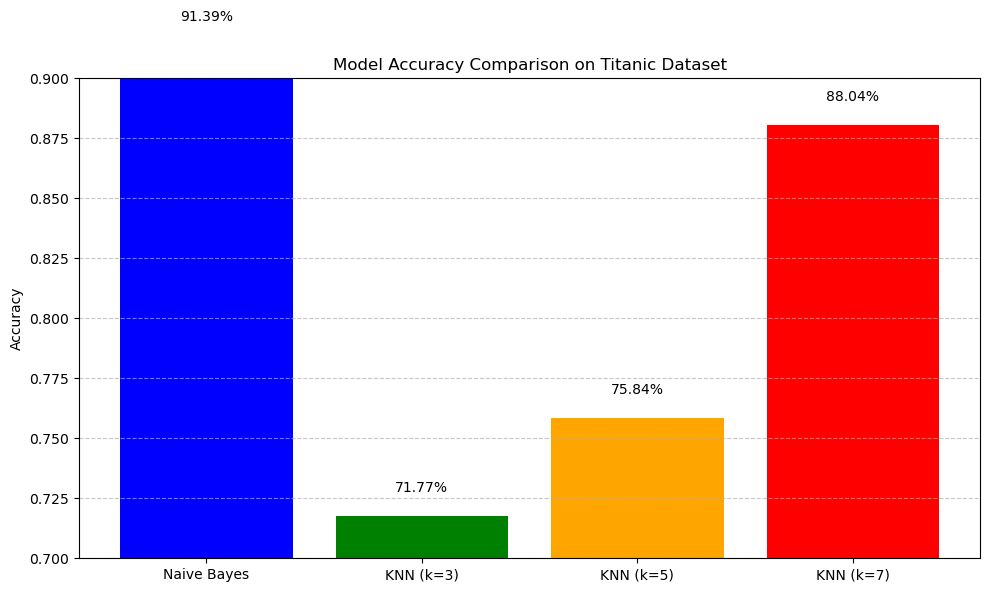

In [32]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_data()

    nb_model = naive_bayes(X_train, y_train)
    y_pred_nb = predict_naive_bayes(nb_model, X_test)
    nb_acc = evaluate(y_test, y_pred_nb, "Naive Bayes")

    k_values = [3, 5, 7]
    knn_accuracies = []
    for k in k_values:
        y_pred_knn = knn(X_train, y_train, X_test, k=k)
        acc = evaluate(y_test, y_pred_knn, f"KNN (k={k})")
        knn_accuracies.append(acc)

    plot_accuracies([nb_acc] + knn_accuracies, ['Naive Bayes'] + [f'KNN (k={k})' for k in k_values])
